In [6]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
sns.set()

In [19]:
# Part 0: Collect data by name and print all names...

def gather_data():
    data_file = open('../quarantine_by_props_1016A.pkl', 'rb')
    data = pickle.load(data_file)
    data_by_name = {}
    for datum in data:
        name = datum.get('name')
        if name not in data_by_name:
            data_by_name[name] = [] 
        data_by_name[name].append(datum)
    return data_by_name

def group_by_qprop(series):
    gather = {} 
    for datum in series:
        qprop = datum['quarantine_props']
        if qprop not in gather:
            gather[qprop] = [] 
        gather[qprop].append(datum)
        
    # and now modify to only collect final_R, max_I
    output = {}
    for qprop, datalist in gather.items():
        final_rs = [_['final_R'] for _ in datalist]
        max_is = [_['max_I'] for _ in datalist]
        output[qprop] = {'final_R': final_rs, 
                         'max_I': max_is}
    return output

def gather_by_name(data, name, i_or_r):
    # Gather triples of [(qprop, mean, std), ...]
    assert i_or_r in ['I', 'R']
    series = group_by_qprop(data[name])
    output = []
    def getter(doc):
        if i_or_r == 'I':
            return doc['max_I']
        else:
            return doc['final_R']
        
        
    for k, v in series.items():
        mean = np.mean(getter(v))
        std = np.std(getter(v))
        output.append((k, mean, std))
        
    return sorted(output, key=lambda trip: trip[0])
    

def size_lookup_by_name(name):
    if name in SYNTHETICS:
        return 10 ** 4 
    elif name.startswith('fb.'):
        return len(gg.load_gemsec_fb(name.split('.')[1]))
    elif name.startswith('deezer.'):
        return len(gg.load_gemsec_deezer(name.split('.')[1]))
    elif name.startswith('arxiv.'):
        return len(gg.load_arxiv_collab(name.split('.')[1]))
    elif name.startswith('hiv') or name.startswith('hs'):
        G = recreate_by_name(name)
        return len(G)
    
    
def recreate_by_name(name):
    # Don't worry too much about actual random seed, just gather parameters
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(name[2:]))
    elif name.startswith('plc'):
        m, p = name[3:].split('.')
        return gg.plc_graph(10 **4, int(m), float(p) / 100)
    elif name.startswith('rw'):
        assert name == 'rw.91.94'
        return gg.random_walk_graph(10 ** 4, 0.91, 0.94)
    elif name.startswith('nn'):
        assert name == 'nn.886'
        return gg.nearestNeighbor_mod(10 **4, 0.88,6)
    elif name.startswith('ws'):
        assert name == 'ws10.05'
        return gg.watts_strogatz_graph(10 ** 4, 10, 0.05)
    elif name.startswith('fb.'):
        return gg.load_gemsec_fb(name.split('.')[1])
    elif name.startswith('deezer.'):
        return gg.load_gemsec_deezer(name.split('.')[1])
    elif name.startswith('arxiv.'):
        return gg.load_arxiv_collab(name.split('.')[1])
    elif name.startswith('hs'):
        params = name[2:].split('_')
        return gg.load_highschool(float(params[0]), int(params[1]))
    elif name.startswith('hiv'):
        param = int(name[3:].split('R')[0])
        return gg.load_hiv(param)
    else:
        raise Exception("wut")
    return
    
  




In [23]:
#fig, ax = plt.subplots(figsize=(10,10)) #<---- general axis maker
def plot_vs(data, names, irs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    if not isinstance(names, list):
        names = [names]
    def plot_single_v(name, ir, ax=ax):
        size = 10 ** 4 # size_lookup[name]
        i_trips = gather_by_name(data, name, 'I')
        r_trips = gather_by_name(data, name, 'R')
        qprops = [_[0] for _ in i_trips]
        Is = [_[1] / size for _ in i_trips]
        qprops_r = [_[0] for _ in r_trips]
        Rs = [_[1] / size for _ in r_trips]
        if 'I' in ir:
            ax.plot(qprops, Is, label=name)
        if 'R' in ir:
            ax.plot(qprops, Rs, label=name)
    
    
    for name in names:
        plot_single_v(name, irs, ax=ax)
    ax.legend()

In [4]:
data = gather_data()
SYNTHETICS = ['ba10', 'ba5', 'plc10.25', 'plc5.5', 'rw.91.94', 'nn.886', 'ws10.05',]
EPIS = [_ for _ in data if (_.startswith('hs') or _.startswith('hiv'))]
REALS = [_ for _ in data if _ not in SYNTHETICS]
#size_lookup = {k: size_lookup_by_name(k) for k in data}

In [13]:
pprint([_ for _ in data.keys() if _.startswith('plc')])

['plc10.25',
 'plc5.5',
 'plc_5_0.5_0.03125',
 'plc_5_0.5_0.25',
 'plc_5_0.5_0.0625',
 'plc_10_0.25_0.03125',
 'plc_5_0.5_0.125',
 'plc_10_0.25_0.125',
 'plc_5_0.5_2',
 'plc_5_0.5_0.5',
 'plc_5_0.5_8',
 'plc_5_0.5_1',
 'plc_10_0.25_0.0625',
 'plc_5_0.5_4',
 'plc_10_0.25_4',
 'plc_10_0.25_0.25',
 'plc_10_0.25_0.5',
 'plc_10_0.25_1',
 'plc_10_0.25_2',
 'plc_10_0.25_8']


In [33]:

def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs

def return_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    return xform 



def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs


def get_powerlaw_exponent_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    #plt.scatter(*zip(*xform))
    slope, intercept, r_value, p_value, std_err = stats.linregress(*zip(*xform))
    return 1 -slope

        
def collect_graph_data_by_name(name, data=data):
    # Returns graph [name, nodes, average degree, cluster coefficient, powerlaw exponent, best_iTup, bestrTup] 
    G = recreate_by_name(name)
    nodes = len(G)
    avg_deg = sum(dict(G.degree()).values()) / len(G)
    cc = nx.average_clustering(G)
    powerlaw = get_powerlaw_exponent_cbin(G)
    no_q = gather_by_name(data, name, 'R')[0][1] /len(G)
    best_i = min(gather_by_name(data, name, 'I'), key=lambda tri: tri[1])
    best_i_prop = best_i[0]
    best_i_val = best_i[1] / nodes
    best_r = min(gather_by_name(data, name, 'R'), key=lambda tri: tri[1])
    best_r_prop = best_r[0]
    best_r_val = best_r[1] / nodes
    return [name, nodes, avg_deg, cc, powerlaw, no_q, best_r_prop, best_r_val]


def tabulate_by_name(names):
    headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'no_Q', 'best_r_prop', 'best_r_val']
    graph_data = [collect_graph_data_by_name(_) for _ in names]
    print(tabulate(graph_data, headers=headers, floatfmt='.2f'))
    return graph_data

In [25]:
NAME = 'plc5.5'
cbin_van = return_cbin(recreate_by_name(NAME))


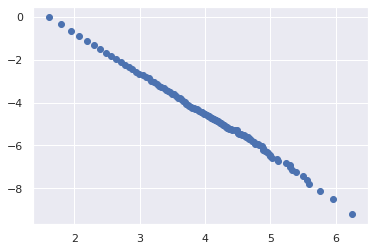

In [26]:
plt.scatter(*zip(*cbin_van))

plc10.25


/home/matt/config/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


plc5.5


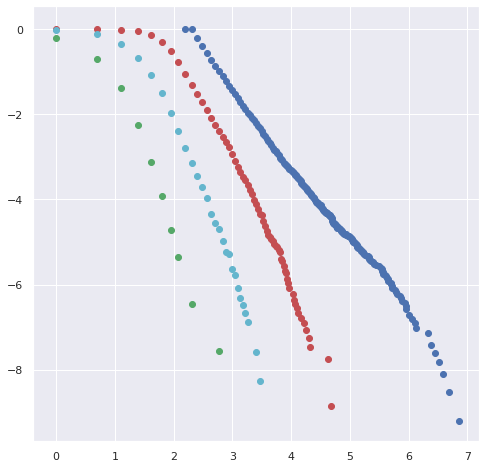

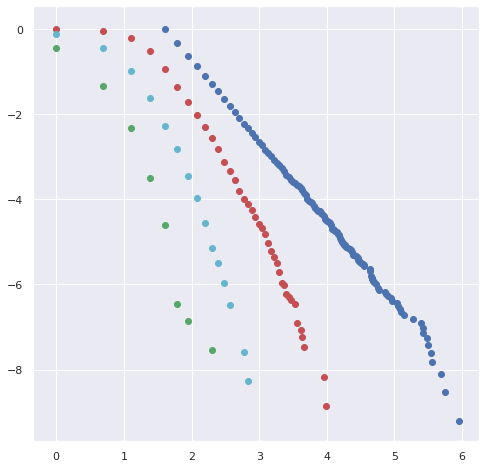

In [66]:
for NAME in SYNTHETICS[2:4]:
    print(NAME)
    fig, ax = plt.subplots(figsize=(8,8))
    G0 = recreate_by_name(NAME)
    G1 = Q.run_until_prop_IR(recreate_by_name(NAME), 1, 1, 10/ (1e4), float('inf'), 0.30)[0]
    G2 = Q.run_until_prop_IR(recreate_by_name(NAME), 1, 1, 10/ (1e4), float('inf'), 0.61)[0]
    G3 = Q.run_until_prop_IR(recreate_by_name(NAME), 1, 1, 10/ (1e4), float('inf'), 0.81)[0]
    ax.scatter(*zip(*return_cbin(G0)), c='b')

    ax.scatter(*zip(*return_cbin(G1)), c='r')
    ax.scatter(*zip(*return_cbin(G2)), c='c')
    ax.scatter(*zip(*return_cbin(G3)), c='g')

In [58]:
for G in [G0, G1, G2]:
    print(nx.average_clustering(G))
    print(nx.number_connected_components(G))

0.02236565977906071
1
0.01773630236068791
53
0.00935368234915746
494


In [57]:
nx.average_shortest_path_length(G0)

KeyboardInterrupt: 

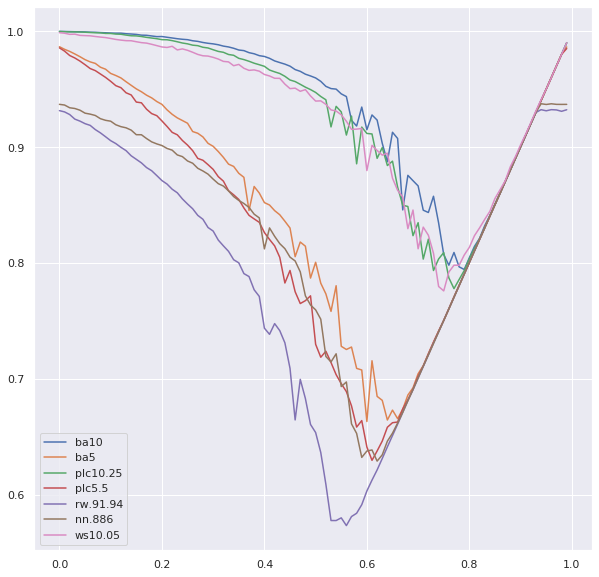

In [63]:
plot_vs(data, SYNTHETICS, 'R')

In [71]:
# How does average clustering change over time 
# First do a description on clustering in general: 
N = 10 ** 4 
cc = lambda graph: nx.average_clustering(graph)

for _ in range(11):
    p = _ / 10
    print(p, cc(gg.plc_graph(N, 5,p)))


0.0 0.007074881743266609
0.1 0.03977530541917225
0.2 0.07391182743151713
0.3 0.11023089587518337
0.4 0.1429662392101596
0.5 0.1779926079319256
0.6 0.21245849593897437
0.7 0.2533772288037644
0.8 0.2963709536631919
0.9 0.349119204004497
1.0 0.4230885495972041


In [72]:
cc(gg.load_gemsec_fb('artist'))

0.13811495287065234

In [73]:
fb_artist = gg.load_gemsec_fb('artist')

In [76]:
sum(dict(fb_artist.degree()).values()) / len(fb_artist)

32.4368826335689

In [79]:
sum(dict(gg.plc_graph(N, 16, 0.8).degree()).values()) / N

31.915

In [86]:
cc(gg.plc_graph(N, 16, 0.9))

0.12846093785553422

In [93]:
nx.degree_assortativity_coefficient(gg.plc_graph(N, 16, 0.9))

-0.03423853898968863

In [94]:
nx.degree_assortativity_coefficient(fb_artist)

-0.019065618803012312

In [96]:
ccs = []
G = gg.plc_graph(N, 16, 0.9)
for _ in range(25):
    print(_)
    Gout = Q.run_until_prop_IR(G, 1, 1, 10 / N, float('inf'), _ / 25)[0]
    ccs.append((_ / 25, cc(Gout)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


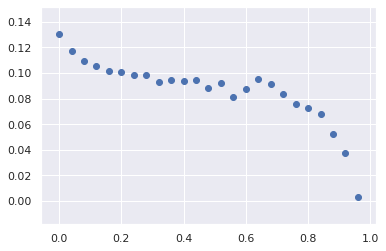

In [97]:
plt.scatter(*zip(*ccs))

In [100]:
cc(recreate_by_name('nn.886')) #SYNTHETICS

0.12154745008482089

In [101]:
NNccs = []
NNG = recreate_by_name('nn.886')
for _ in range(25):
    print(_)
    Gout = Q.run_until_prop_IR(NNG, 1, 1, 10 / N, float('inf'), _ / 25)[0]
    NNccs.append((_ / 25, cc(Gout)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


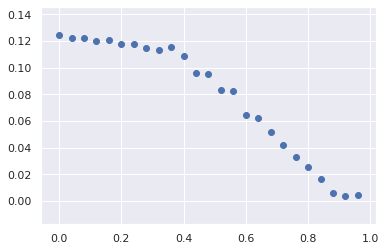

In [103]:
plt.scatter(*zip(*NNccs))

In [106]:
company = gg.load_gemsec_fb('company')
com_ccs = []
for _ in range(25):
    print(_)
    Gout = Q.run_until_prop_IR(company, 1, 1, 10 / N, float('inf'), _ / 25)[0]
    com_ccs.append((_ / 25, cc(Gout)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


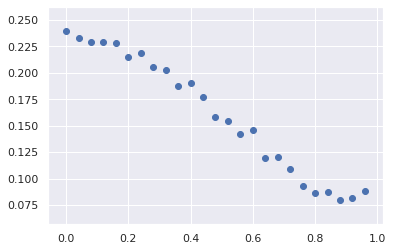

In [107]:
plt.scatter(*zip(*com_ccs))

plc5.5


/home/matt/config/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


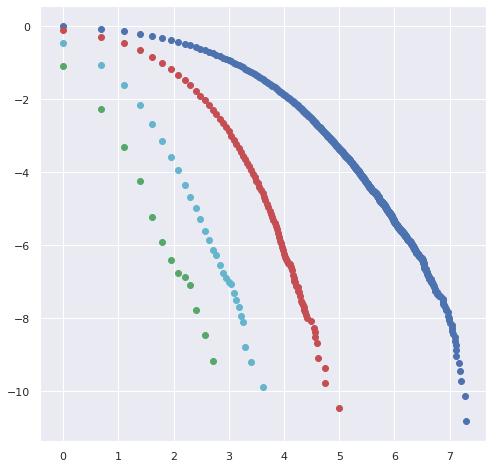

In [110]:
if True:
    company =fb_artist
    print(NAME)
    fig, ax = plt.subplots(figsize=(8,8))
    G0 = company
    G1 = Q.run_until_prop_IR(company, 1, 1, 10/ (1e4), float('inf'), 0.30)[0]
    G2 = Q.run_until_prop_IR(company, 1, 1, 10/ (1e4), float('inf'), 0.61)[0]
    G3 = Q.run_until_prop_IR(company, 1, 1, 10/ (1e4), float('inf'), 0.81)[0]
    ax.scatter(*zip(*return_cbin(G0)), c='b')

    ax.scatter(*zip(*return_cbin(G1)), c='r')
    ax.scatter(*zip(*return_cbin(G2)), c='c')
    ax.scatter(*zip(*return_cbin(G3)), c='g')

In [115]:
rw = gg.random_walk_graph(N, 0.9, 0.9)

for i in range(10):
    qv = (40 +i) / 50
    print(qv, cc(gg.random_walk_graph(N, qv, .9)))

0.8 0.42200473506171304
0.82 0.39892012940020205
0.84 0.3819441393781111
0.86 0.35955435548827375
0.88 0.33355958256051493
0.9 0.3072029483278399
0.92 0.26707748938397624
0.94 0.22280800790242314
0.96 0.18306707492236057
0.98 0.1462042517978086


In [116]:
"""
Structural changes that occur to graphs during a run :
Plot: - drop in clustering coefficient
      - drop in scale-free parameter 
      - drop in average degree 
      - drop in average path length 
"""


def get_minR_graph(data, name):
    # Gathers the graph (after minR optimal quarantine) 
    # 1) Get minR prop:
    
    # 2) Recreate graph and rerun 
    
    

'\nStructural changes that occur to graphs during a run :\n'